In [54]:
import sys
print(sys.version)

3.7.0 (default, Jun 28 2018, 13:15:42) 
[GCC 7.2.0]


In [170]:
from dataclasses import dataclass, field
from typing import Union
from IPython.display import clear_output
from time import sleep
import matplotlib.pyplot as plt
%matplotlib inline

In [249]:
@dataclass
class Worker:
    todo: int = 0
    doing: int = 0
    outbox: int = 0
    target: Union[Worker, type(None)] = field(default=None, repr=False)
    task_duration: int = field(default=1, repr=False)
    batch_size: int = field(default=1, repr=False)
    max_todo: Union[int, type(None)] = field(default=None, repr=False)
    _task_time: int = field(default=0, repr=False)
    
        
    def work(self):
        
        if not self.doing and self.todo:
            self.todo -= 1
            self.doing += 1
        if self.doing:
            self._task_time += 1
            if self._task_time >= self.task_duration:
                self.doing = 0
                self._task_time = 0
                self.outbox += 1
    
    def push(self):
        if self.outbox >= self.batch_size:
            to_push = self.batch_size
        elif self.outbox and not any([self.todo, self.doing]):
            to_push = self.outbox
        else:
            to_push = 0
        
        if not self.target:
            self.outbox -= to_push
        elif not self.target.max_todo:
            self.target.todo += to_push
            self.outbox -= to_push
        elif self.target.max_todo >= self.target.todo + self.target.doing + to_push:
            self.target.todo += to_push
            self.outbox -= to_push
                    
        
    @property
    def wip(self):
        return self.todo + self.doing + self.outbox

Worker(todo=3)

Worker(todo=3, doing=0, outbox=0)

In [232]:
w = Worker(todo=2)
print(w)
for el in range(4):
    w.push()
    w.work()
    print(w)

Worker(todo=2, doing=0, outbox=0)
Worker(todo=1, doing=0, outbox=1)
Worker(todo=0, doing=0, outbox=1)
Worker(todo=0, doing=0, outbox=0)
Worker(todo=0, doing=0, outbox=0)


In [252]:
class Workflow:
    
    def __init__(self, workers):
        self.workers = workers
        
    @property
    def wip(self):
        return sum(w.wip for w in self.workers)
        
    def step(self):
        for worker in self.workers[::-1]:
            worker.push()
            worker.work()

    def process(self, work, verbose=False, interactive=True, sleep_time=0.1):
        """Returns number of steps to process some piece of work."""
        self.workers[0].todo = 20
        steps = 0
        while self.wip:
            steps += 1
            self.step()
            if verbose:
                if interactive:
                    clear_output()
                print(workflow)
                print(f'Steps: {steps}', end='\n\n', flush=True)
                if interactive:
                    sleep(sleep_time)
        return steps
    
    def __repr__(self):
        rep = ''
        for attr in ['todo', 'doing', 'outbox']:
                rep += f'{attr}:\t(' + '->\t'.join(f'{getattr(w, attr)}' for w in self.workers) + ')\n'
        rep += 'WIP:\t {}\n'.format("\t".join(str(w.wip) for w in self.workers))
        rep += f'Total WIP: {self.wip}'
        return rep
    
    @classmethod
    def run_chained_process(cls, work=20, workers=4, batch_size=1, verbose=False):
        queue = [Worker(batch_size=batch_size) for _ in range(4)]
        for w1, w2 in zip(queue[:-1], queue[1:]):
            w1.target = w2
        
        workflow = cls(workers=queue)
        steps = workflow.process(work=work, verbose=verbose)
        return steps

In [262]:
queue = [Worker(batch_size=1, task_duration=2) for _ in range(4)]
for w1, w2 in zip(queue[:-1], queue[1:]):
    w1.target = w2

# queue[1].task_duration = 2
queue[1].max_todo = None
workflow = Workflow(workers=queue)
workflow.process(20, verbose=True, interactive=True, sleep_time=0.1)

todo:	(0->	0->	0->	0)
doing:	(0->	0->	0->	0)
outbox:	(0->	0->	0->	0)
WIP:	 0	0	0	0
Total WIP: 0
Steps: 50



50

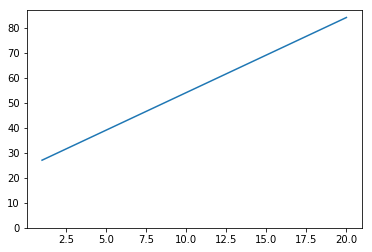

In [255]:
batch_sizes = list(range(1, 21))
total_time = []
for batch_size in batch_sizes:
    steps = Workflow.run_chained_process(work=20, workers=4, batch_size=batch_size)
    total_time.append(steps)
    
plt.plot(batch_sizes, total_time);
plt.ylim(0, plt.gca().get_ylim()[1]);